The purpose of this project is to develop a image recognition model to identify the type of bird in a given image.

Data Set: https://www.kaggle.com/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images

The packages that will be used are from the pytorch library.

In [ ]:
"""
 Final project for CS-4440: Data Science
 Author: Gideon Landry
 Date: March 03, 2023
"""
# import pytorch packages and lightning
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn, utils, Tensor
from torchvision import datasets, transforms

# test if torch is working and if system supports cuda.
x = torch.rand(5, 3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(x, device.type)

tensor([[0.2372, 0.1473, 0.3299],
        [0.2375, 0.7281, 0.1648],
        [0.8222, 0.3268, 0.2748],
        [0.3479, 0.3781, 0.5245],
        [0.4901, 0.6729, 0.4355]]) cuda


The results above show torch is working and that the current device has cuda support (NVIDIA GPU)

In [ ]:
# get list of bird types.
classes = os.listdir("training_set")

classes_dict = {}
num_dict = {}
i = 0

for c in classes:
    classes_dict[c] = i
    num_dict[i] = c
    i = i + 1

print(classes_dict)

{'Asian Green Bee-Eater': 0, 'Brown-Headed Barbet': 1, 'Cattle Egret': 2, 'Common Kingfisher': 3, 'Common Myna': 4, 'Common Rosefinch': 5, 'Common Tailorbird': 6, 'Coppersmith Barbet': 7, 'Forest Wagtail': 8, 'Gray Wagtail': 9, 'Hoopoe': 10, 'House Crow': 11, 'Indian Grey Hornbill': 12, 'Indian Peacock': 13, 'Indian Pitta': 14, 'Indian Roller': 15, 'Jungle Babbler': 16, 'Northern Lapwing': 17, 'Red-Wattled Lapwing': 18, 'Ruddy Shelduck': 19, 'Rufous Treepie': 20, 'Sarus Crane': 21, 'White Wagtail': 22, 'White-Breasted Kingfisher': 23, 'White-Breasted Waterhen': 24}


We see that there are total of 25 bird species in this data set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


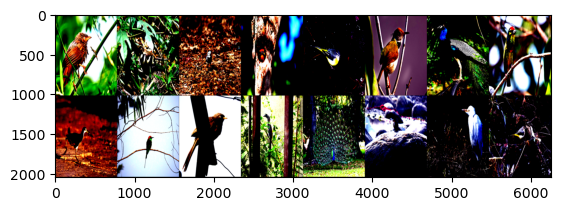

Jungle Babbler; Forest Wagtail; White Wagtail; Coppersmith Barbet; Gray Wagtail; Common Tailorbird; Indian Peacock; Coppersmith Barbet; White-Breasted Waterhen; Asian Green Bee-Eater; Jungle Babbler; Indian Grey Hornbill; Indian Peacock; White-Breasted Kingfisher; Cattle Egret; Gray Wagtail


In [ ]:
# set the size of the individual batchs
batch_size = 16

# transform function will transform each image size, normalization values where generated using code from https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html
transform_img = transforms.Compose([transforms.Resize((1020,780)),
                                    transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.5010, 0.5117, 0.4275],
                                                       std = [0.2255, 0.2216, 0.2610])
                                   ])

# create dataset
data_set = datasets.ImageFolder("training_set",transform=transform_img)
# get mean and standard deviation of data for normalization
#mean, std = data_set.mean([1,2]), data_set.std([1,2])


# split data set(80% for training, 20% for testing)
split_generator = torch.Generator().manual_seed(19)
train,test = utils.data.random_split(data_set,[0.8,0.2],generator=split_generator)


train_loader = utils.data.DataLoader(train, batch_size = batch_size, shuffle=True)
test_loader = utils.data.DataLoader(test, batch_size = batch_size, shuffle=True)

train_features, train_labels = next(iter(train_loader))

import torchvision.utils as utils2

npimg = utils2.make_grid(train_features).numpy()
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()
print('; '.join(f'{classes[train_labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# code below is from https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html
# this code will find the mean and standard deviation for data set to be used to normalize image.
from torch.utils.data import DataLoader
loader = DataLoader(
  data_set,
  batch_size = batch_size,
  num_workers=1)

def batch_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)
    return mean,std

mean, std = batch_mean_and_sd(loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.5010, 0.5117, 0.4275]) tensor([0.2255, 0.2216, 0.2610])


In [ ]:
    # the following code shows how the dimensions of image change as they go threw layers of neural network.
    conv1 = nn.Conv2d(3, 6, 5)
    pool = nn.MaxPool2d(2, 2)
    conv2 = nn.Conv2d(6, 16, 5)
    print(train_features.shape)
    x = conv1(train_features)
    print(x.shape)
    x = pool(x)
    print(x.shape)
    x = conv2(x)
    print(x.shape)
    x = pool(x)
    print(x.shape)

    # Capture image dimensions to use in neural network.
    x,y,z = x.shape[1:4]
    print(x,y,z)
    #x = torch.flatten(x, 1) # flatten all dimensions except batch
    #print(x.shape)

torch.Size([16, 3, 1020, 780])
torch.Size([16, 6, 1016, 776])
torch.Size([16, 6, 508, 388])
torch.Size([16, 16, 504, 384])
torch.Size([16, 16, 252, 192])
16 252 192


In [ ]:
# based on code from following page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # input image dimensions for fc1 layer.
        self.fc1 = nn.Linear(x * y * z, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# train model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

# save model for use later.
PATH = './net.pth'
torch.save(net.state_dict(), PATH)
print('Finished Training')

Finished Training


In [ ]:
# load model
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

# test model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 32 %


For the first attempt I choose to transform image to a resolution of 255 x 170 with no normalization and batch size of 32. After trainning the model I tested it with a result of 3% accuracy.
To improve accuracy for second attempt, I ajusted image resolution to 510 x 340 with a result of 16%.
For the third attempt i used a resolution of 1020 X 780 and a batch size of 16 with result of 25%.
Tried again without normalization and accuracy dropped to 19%.
For final attempt i used more optimized normalization values and got a result of 32% accuracy, the best so far but still to low for any practical use.

The low accuracy is most likely a result of a poor neural network set up. Applying more layers or changing the number of features may improve accuracy.   
